In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
from typing import Union, Tuple

from infovar.stats.entropy_estimators import mi as mi_knn

In [2]:
def mi_histogram(x: np.ndarray, y: np.ndarray, bins: Union[None, int, Tuple[int, int]]=None, base: float=2) -> float:
    x = x.flatten() # Only work for 1D arrays
    y = y.flatten() # Only work for 1D arrays

    if bins is None:
        bins_x = len(np.histogram_bin_edges(x))
        bins_y = len(np.histogram_bin_edges(y))
    elif isinstance(bins, int):
        bins_x, bins_y = bins, bins
    elif isinstance(bins, Tuple):
        bins_x, bins_y = bins

    pdf_x, x_edges = np.histogram(x, bins=bins_x, density=True)
    pdf_y, y_edges = np.histogram(y, bins=bins_y, density=True)
    pdf_xy, _, __ = np.histogram2d(x, y, bins=(len(x_edges)-1, len(y_edges)-1), density=True)

    x_bins_w = x_edges[1] - x_edges[0]
    y_bins_w = y_edges[1] - y_edges[0]

    prev = np.seterr(all="ignore")
    pdf_x = pdf_x[:, np.newaxis]
    pdf_y = pdf_y[np.newaxis, :]
    integrand = pdf_xy * np.log(pdf_xy / (pdf_x * pdf_y)) / np.log(base)
    integrand[~np.isfinite(integrand)] = 0.
    mi = integrand.sum() * x_bins_w * y_bins_w
    np.seterr(**prev)

    return mi

def mi_kde(x: np.ndarray, y: np.ndarray, points: int=1_000, base: float=2) -> float:
    kde_xy = gaussian_kde(np.column_stack((x, y)).T)
    kde_x = gaussian_kde(x.T)
    kde_y = gaussian_kde(y.T)

    sx = 1.06 * np.std(x, axis=0) * x.shape[0]**(-1/5)
    sy = 1.06 * np.std(y, axis=0) * y.shape[0]**(-1/5)
    n_sigma = 5

    tx = np.linspace(x.min(axis=0)-n_sigma*sx, x.max(axis=0)+n_sigma*sx, points)
    ty = np.linspace(y.min(axis=0)-n_sigma*sy, y.max(axis=0)+n_sigma*sy, points)

    Tx, Ty = np.meshgrid(tx, ty)
    Tx, Ty = Tx.flatten(), Ty.flatten()

    pdf_xy = kde_xy.evaluate(np.column_stack((Tx, Ty)).T).reshape(points, points)
    pdf_x = kde_x.evaluate(tx.T)
    pdf_y = kde_y.evaluate(ty.T)

    hx = tx[1, :] - tx[0, :]
    hy = ty[1, :] - ty[0, :]

    prev = np.seterr(all="ignore")
    integrand = pdf_xy * np.log(pdf_xy / (pdf_x * pdf_y)) / np.log(base)
    integrand[~np.isfinite(integrand)] = 0.
    mi = integrand.sum() * np.prod(hx) * np.prod(hy)
    np.seterr(**prev)

    return mi

In [3]:
rho = 0.8
sigmax, sigmay = 2, 1

def get_data(n_samples: int):
    mus = np.array([0, 0])
    sigmas = np.array([[sigmax**2, sigmax*sigmay*rho], [sigmax*sigmay*rho, sigmay**2]])

    data = np.random.multivariate_normal(mus, sigmas, size=n_samples)
    x = data[:, 0].reshape(-1, 1)
    y = data[:, 1].reshape(-1, 1)
    return x, y

def mi_analytic(base: float=2):
    return - 0.5 * np.log(1-rho**2) / np.log(base)

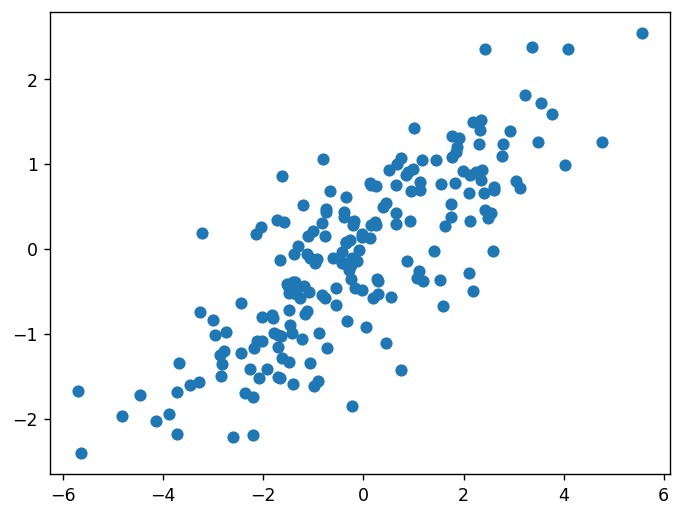

In [4]:
plt.figure(dpi=125)

plt.scatter(*get_data(200))

plt.show()

## Accuracy

In [7]:
n_iter = 20
n_samples = 1_000

mi_true = mi_analytic()

mi_knn_list = []
mi_histogram_list = []
mi_kde_list = []
for _ in tqdm(range(n_iter)):

    x, y = get_data(n_samples)

    mi_knn_list.append(mi_knn(x, y))
    mi_histogram_list.append(mi_histogram(x, y))
    mi_kde_list.append(mi_kde(x, y, points=300))

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


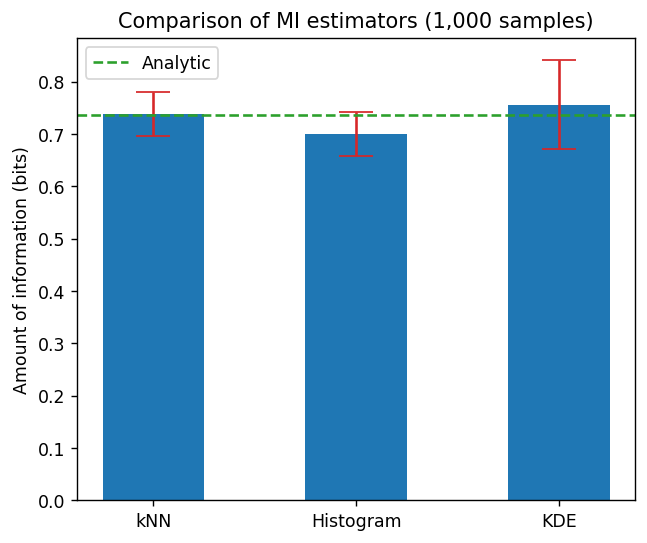

In [8]:
plt.figure(figsize=(0.9*6.4, 4.8), dpi=125)

xticks = [0, 1, 2]
heights = [np.mean(mi_knn_list), np.mean(mi_histogram_list), np.mean(mi_kde_list)]
yerrs = [np.std(mi_knn_list), np.std(mi_histogram_list), np.std(mi_kde_list)]

plt.bar(xticks, heights, width=0.5)
plt.errorbar(xticks, heights, yerr=yerrs, fmt="none", color="tab:red", capsize=10)
plt.axhline(mi_true, linestyle="--", color="tab:green", label="Analytic")
plt.xticks(xticks, labels=["kNN", "Histogram", "KDE"])

plt.ylabel("Amount of information (bits)")
plt.title(f"Comparison of MI estimators ({n_samples:,} samples)")
plt.legend()

plt.show()

## Accuracy (with bootstrapping)

In [17]:
mi_knn_list = []
mi_histogram_list = []
mi_kde_list = []
x, y = get_data(n_samples)
for _ in tqdm(range(n_iter)):

    idx = np.random.choice(n_samples, size=n_samples, replace=True)
    _x = x[idx] + np.random.normal(0, 1e-1, size=x.shape)
    _y = y[idx] + np.random.normal(0, 1e-1, size=y.shape)

    mi_knn_list.append(mi_knn(_x, _y))
    mi_histogram_list.append(mi_histogram(_x, _y))
    mi_kde_list.append(mi_kde(_x, _y, points=300))

100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


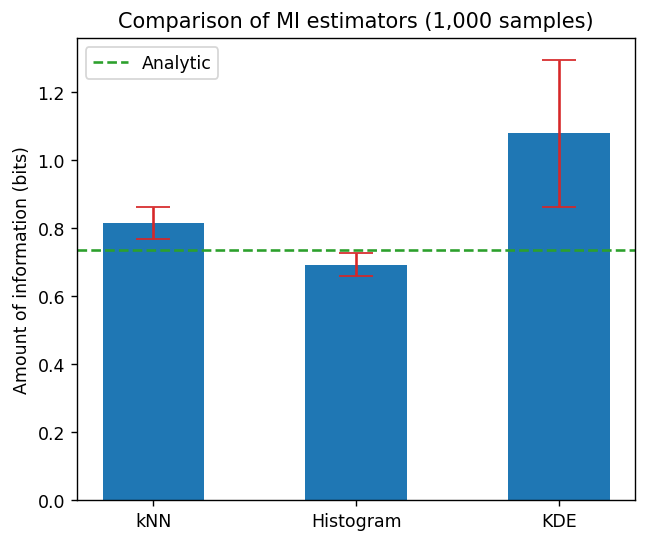

In [18]:
plt.figure(figsize=(0.9*6.4, 4.8), dpi=125)

xticks = [0, 1, 2]
heights = [np.mean(mi_knn_list), np.mean(mi_histogram_list), np.mean(mi_kde_list)]
yerrs = [np.std(mi_knn_list), np.std(mi_histogram_list), np.std(mi_kde_list)]

plt.bar(xticks, heights, width=0.5)
plt.errorbar(xticks, heights, yerr=yerrs, fmt="none", color="tab:red", capsize=10)
plt.axhline(mi_true, linestyle="--", color="tab:green", label="Analytic")
plt.xticks(xticks, labels=["kNN", "Histogram", "KDE"])

plt.ylabel("Amount of information (bits)")
plt.title(f"Comparison of MI estimators ({n_samples:,} samples)")
plt.legend()

plt.show()